# Interactive inference

In [607]:
%load_ext autoreload

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [608]:
%autoreload 2

In [736]:
from models.single_policy import SinglePolicy
from single_agent import SingleAgent
from IPython.display import SVG, display, HTML
import torch
from torch import distributions
import pdb
import vh_graph
import gym
import envdataset
import utils_viz
import utils
from plotly.offline import init_notebook_mode, iplot

init_notebook_mode(connected=True)
import sys
from IPython.display import Image
sys.argv = ['-f'] 

In [755]:
import scipy.special
from plotly.subplots import make_subplots
import plotly.graph_objects as go
def obtain_belief(bel, object_id):
    belief_inside = bel.edge_belief[object_id]['INSIDE']
    belief_on = bel.edge_belief[object_id]['ON']
    rooms = bel.room_node[object_id]
    
    
    room_probs = scipy.special.softmax(rooms[1])
    inside_probs = scipy.special.softmax(belief_inside[1])
    on_probs = scipy.special.softmax(belief_on[1])
    names1 = ['node_'+str(x) for x in list(belief_on[0])]
    names2 = ['node_'+str(x) for x in list(belief_inside[0])]
    names3 = ['node_'+str(x) for x in list(rooms[0])]
    return (names1, on_probs), (names2, inside_probs), (names3, room_probs)

def plot_belief(bel, object_id):
    resp = obtain_belief(bel, object_id)
    fig = make_subplots(rows=3, cols=1)
    names = ['objects on', 'objects inside', 'rooms']
    for elem in range(3):
        name_and_probs = resp[elem]
        barp = go.Bar(y=resp[elem][1], x=resp[elem][0], orientation='v', name=names[elem])
        fig.add_trace(barp, row=elem+1, col=1)
    fig.show()
from IPython.display import clear_output
import time

In [756]:
curr_env = gym.make('vh_graph-v0')

In [777]:
weights = 'logdir/dataset_folder.dataset_toy4_pomdp.False_graphsteps.3_training_mode.pg/offp.False_eps.0.2_gamma.0.7/2019-11-14_00.45.32.080556/chkpt/chkpt_149.pt'
#weights = ('logdir/dataset_folder.dataset_toy4_pomdp.False_graphsteps.3_training_mode.pg_invertedge.True/'
#          'offp.False_eps.0.2_gamma.0.7/2019-11-20_15.20.44.417376/chkpt/chkpt_249.pt')

path_init_env = 'dataset_toy4/init_envs/TrimmedTestScene6_graph_45.json'
args = utils.read_args()
args.max_steps = 1
args.dataset_folder = 'dataset_toy4'
args.interactive = True
#args.invertedge = True

dataset_interactive = envdataset.EnvDataset(args, process_progs=False)
policy_net = SinglePolicy(dataset_interactive).cuda()
policy_net = torch.nn.DataParallel(policy_net)


Getting objects from dataset_toy4/obj_names.json...


In [778]:
curr_env.reset(path_init_env, goal_name)
curr_env.to_pomdp()

goal_name = {0:'(facing living_room[1] living_room[1])'}
single_agent = SingleAgent(curr_env, goal_name, 0, dataset_interactive, policy_net, use_belief=True)
single_agent.policy_net.load_state_dict(torch.load(weights)['model_params'])
_ = single_agent.env.reset(path_init_env, goal_name)




Edges...


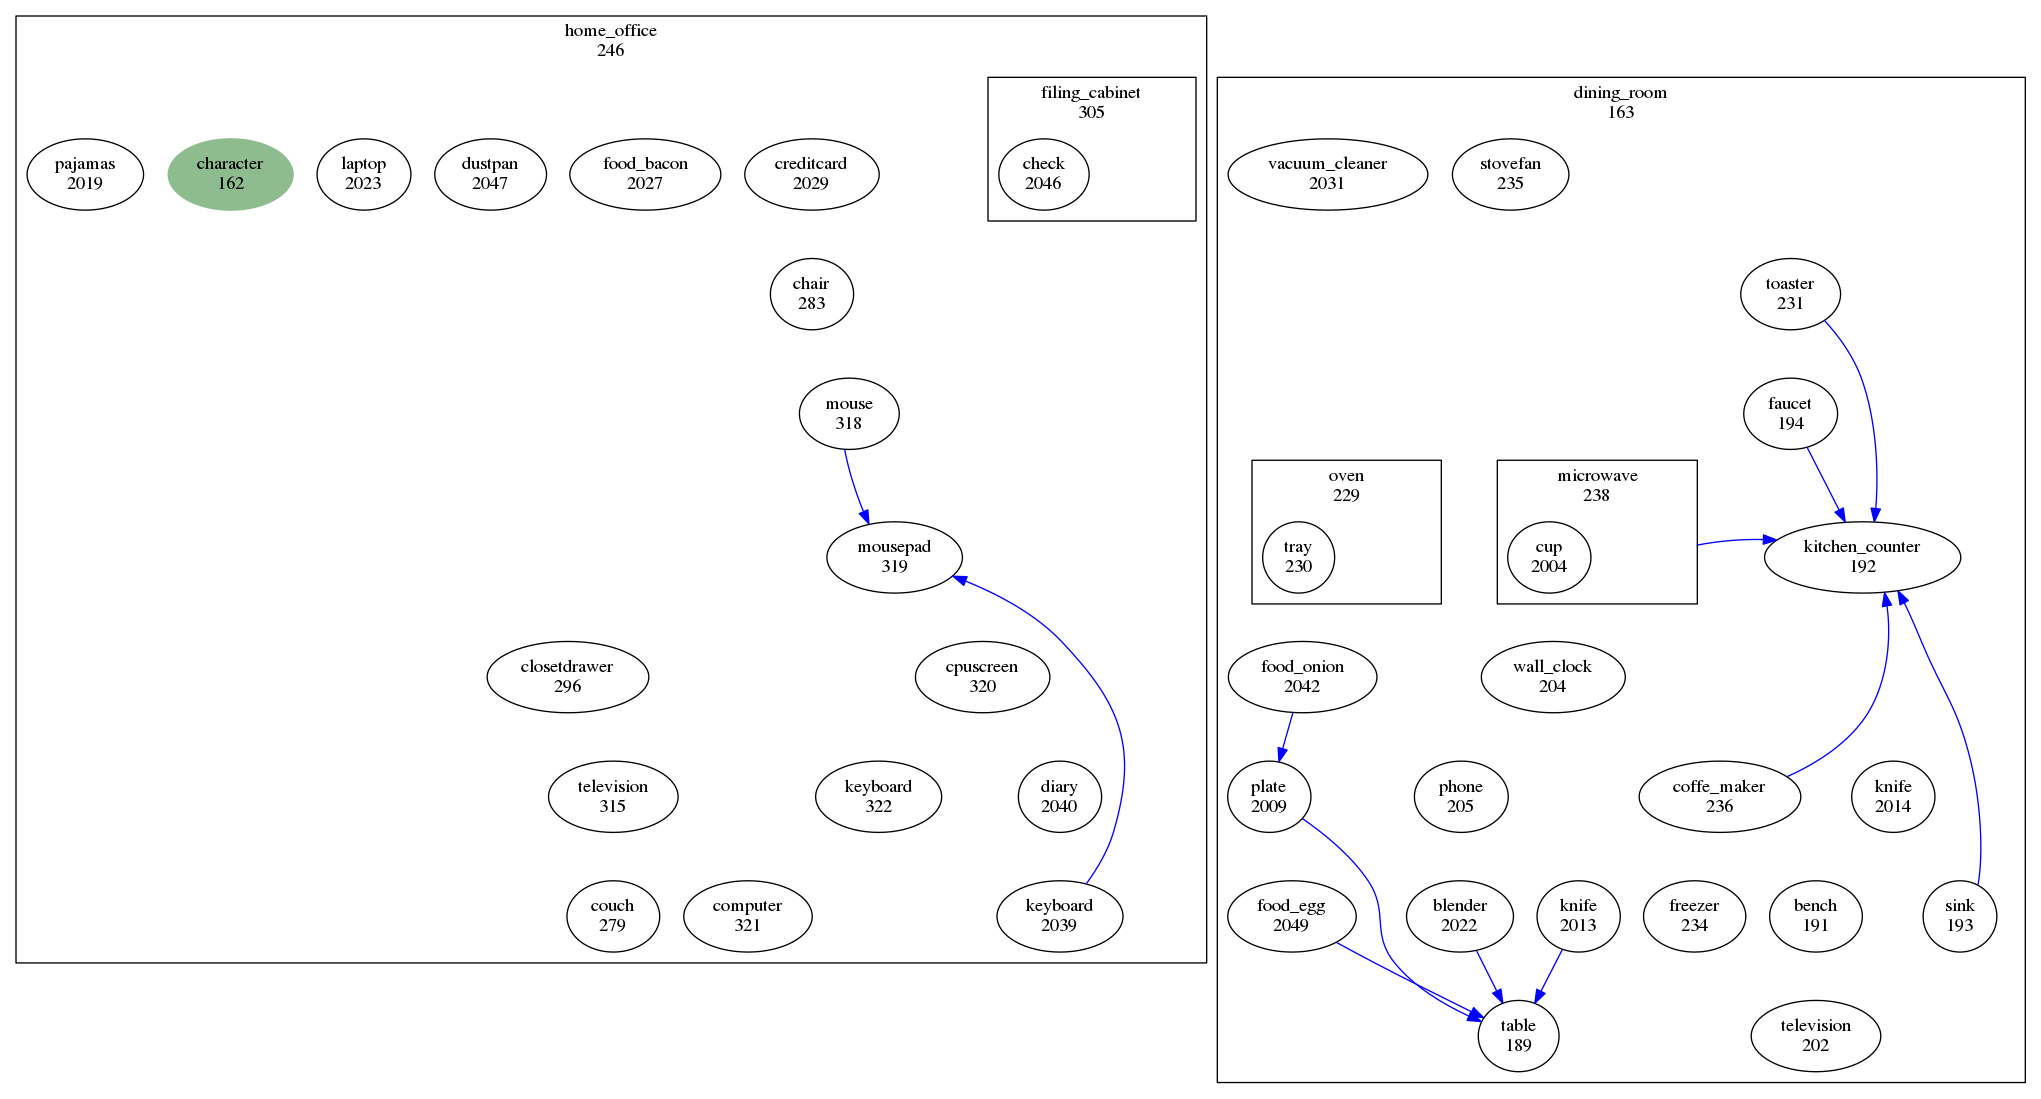

In [779]:
gt_state = curr_env.vh_state.to_dict()
id_agent = [x['id'] for x in gt_state['nodes'] if x['class_name'] == 'character'][0]

graph = utils_viz.graph2im(gt_state, {id_agent: 'agent'})
graph.format = 'png'
tmp = graph.view()
display(Image(tmp))
print()

In [780]:
[x for x in gt_state['nodes'] if x['id'] == 229]

[{'id': 229,
  'class_name': 'oven',
  'category': 'Appliances',
  'properties': ['CAN_OPEN', 'HAS_SWITCH', 'HAS_PLUG', 'CONTAINERS'],
  'states': ['CLOSED', 'OFF'],
  'prefab_name': None,
  'bounding_box': None}]

## Pick an id

In [781]:
obj_id = 230
str_goal = 'findnode_{}'.format(id_goal)

In [782]:
goal_name = {0:'(facing living_room[1] living_room[1])'}
_ = single_agent.env.reset(path_init_env, goal_name)

In [783]:
single_agent.env.reset(path_init_env, goal_name)
print(str_goal)
for i in range(10):
    curr_state = single_agent.env.vh_state.to_dict()
    visible_ids = single_agent.env.observable_object_ids_n[0]
    graph_data, action_logits, o1_logits, o2_logits = single_agent.obtain_logits_from_observations(
                curr_state, visible_ids, str_goal)
    instruction, logits = single_agent.sample_instruction(single_agent.dataset, graph_data,
                                                  action_logits, o1_logits, o2_logits)
    instr = list(zip(*instruction))[0]
    str_instruction = utils.pretty_instr(instr)
    print(str_instruction)
    resp = single_agent.env.step({0: str_instruction})

findnode_230
[walk] <dining_room> (163) 
[walk] <oven> (229) 
[turnto] <vacuum_cleaner> (2031) 
[open] <oven> (229) 
[walk] <stovefan> (235) 
[walk] <tray> (230) 
[open] <microwave> (238) 
[turnto] <vacuum_cleaner> (2031) 
[walk] <vacuum_cleaner> (2031) 
[walk] <dining_room> (163) 


In [785]:
import numpy as np
import random
seed = 8
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
np.random.seed(seed)
random.seed(seed)


single_agent.env.reset(path_init_env, goal_name)
single_agent.previous_belief_graph = None
obs_graph = single_agent.get_observations()
single_agent.sample_belief(obs_graph)

for i in range(50):
    _, instruction, _, _, _ = single_agent.one_step_rollout(str_goal, False, use_belief=True)
    graph_belief = single_agent.belief_sim.vh_state.to_dict()
    edge_interest = [x for x in graph_belief['edges'] if x['from_id'] == obj_id and x['relation_type'] != 'CLOSE']
    print(instruction, edge_interest)
    plot_belief(single_agent.belief, obj_id)
    
# for i in range(3):
#     time.sleep(0.5)
#     clear_output()




[walk] <chair> (283)  [{'from_id': 230, 'relation_type': 'INSIDE', 'to_id': 229}]


[walk] <filing_cabinet> (305)  [{'from_id': 230, 'relation_type': 'INSIDE', 'to_id': 229}]


[walk] <television> (315)  [{'from_id': 230, 'relation_type': 'INSIDE', 'to_id': 229}]


[walk] <dining_room> (163)  [{'from_id': 230, 'relation_type': 'INSIDE', 'to_id': 229}]


[walk] <oven> (229)  [{'from_id': 230, 'relation_type': 'INSIDE', 'to_id': 229}]


[walk] <stovefan> (235)  [{'from_id': 230, 'relation_type': 'INSIDE', 'to_id': 229}]


[walk] <oven> (229)  [{'from_id': 230, 'relation_type': 'INSIDE', 'to_id': 229}]


[open] <oven> (229)  [{'from_id': 230, 'relation_type': 'INSIDE', 'to_id': 229}]


[turnto] <wall_clock> (204)  [{'from_id': 230, 'relation_type': 'INSIDE', 'to_id': 229}]


[turnto] <vacuum_cleaner> (2031)  [{'from_id': 230, 'relation_type': 'INSIDE', 'to_id': 229}]


[open] <microwave> (238)  [{'from_id': 230, 'relation_type': 'INSIDE', 'to_id': 229}]


[turnto] <tray> (230)  [{'from_id': 230, 'relation_type': 'INSIDE', 'to_id': 229}]


[turnto] <faucet> (194)  [{'from_id': 230, 'relation_type': 'INSIDE', 'to_id': 229}]


[move] <tray> (230)  [{'from_id': 230, 'relation_type': 'INSIDE', 'to_id': 229}]


[walk] <table> (189)  [{'from_id': 230, 'relation_type': 'INSIDE', 'to_id': 229}]


[walk] <dining_room> (163)  [{'from_id': 230, 'relation_type': 'INSIDE', 'to_id': 229}]


[walk] <home_office> (246)  [{'from_id': 230, 'relation_type': 'INSIDE', 'to_id': 229}]


[walk] <chair> (283)  [{'from_id': 230, 'relation_type': 'INSIDE', 'to_id': 229}]


[walk] <dining_room> (163)  [{'from_id': 230, 'relation_type': 'INSIDE', 'to_id': 229}]


[walk] <dining_room> (163)  [{'from_id': 230, 'relation_type': 'INSIDE', 'to_id': 229}]


[walk] <plate> (2009)  [{'from_id': 230, 'relation_type': 'INSIDE', 'to_id': 229}]


[walk] <tray> (230)  [{'from_id': 230, 'relation_type': 'INSIDE', 'to_id': 229}]


[walk] <coffe_maker> (236)  [{'from_id': 230, 'relation_type': 'INSIDE', 'to_id': 229}]


[walk] <television> (202)  [{'from_id': 230, 'relation_type': 'INSIDE', 'to_id': 229}]


[walk] <cup> (2004)  [{'from_id': 230, 'relation_type': 'INSIDE', 'to_id': 229}]


[walk] <tray> (230)  [{'from_id': 230, 'relation_type': 'INSIDE', 'to_id': 229}]


[walk] <vacuum_cleaner> (2031)  [{'from_id': 230, 'relation_type': 'INSIDE', 'to_id': 229}]


[walk] <sink> (193)  [{'from_id': 230, 'relation_type': 'INSIDE', 'to_id': 229}]


[walk] <television> (202)  [{'from_id': 230, 'relation_type': 'INSIDE', 'to_id': 229}]


[walk] <freezer> (234)  [{'from_id': 230, 'relation_type': 'INSIDE', 'to_id': 229}]


[walk] <sink> (193)  [{'from_id': 230, 'relation_type': 'INSIDE', 'to_id': 229}]


[walk] <tray> (230)  [{'from_id': 230, 'relation_type': 'INSIDE', 'to_id': 229}]


[turnto] <dining_room> (163)  [{'from_id': 230, 'relation_type': 'INSIDE', 'to_id': 229}]


[turnto] <wall_clock> (204)  [{'from_id': 230, 'relation_type': 'INSIDE', 'to_id': 229}]


[walk] <vacuum_cleaner> (2031)  [{'from_id': 230, 'relation_type': 'INSIDE', 'to_id': 229}]


[walk] <tray> (230)  [{'from_id': 230, 'relation_type': 'INSIDE', 'to_id': 229}]


[turnto] <dining_room> (163)  [{'from_id': 230, 'relation_type': 'INSIDE', 'to_id': 229}]


[touch] <tray> (230)  [{'from_id': 230, 'relation_type': 'INSIDE', 'to_id': 229}]


[walk] <food_onion> (2042)  [{'from_id': 230, 'relation_type': 'INSIDE', 'to_id': 229}]


[walk] <dining_room> (163)  [{'from_id': 230, 'relation_type': 'INSIDE', 'to_id': 229}]


[walk] <plate> (2009)  [{'from_id': 230, 'relation_type': 'INSIDE', 'to_id': 229}]


[walk] <tray> (230)  [{'from_id': 230, 'relation_type': 'INSIDE', 'to_id': 229}]


[walk] <home_office> (246)  [{'from_id': 230, 'relation_type': 'INSIDE', 'to_id': 229}]


[walk] <dining_room> (163)  [{'from_id': 230, 'relation_type': 'INSIDE', 'to_id': 229}]


[walk] <tray> (230)  [{'from_id': 230, 'relation_type': 'INSIDE', 'to_id': 229}]


[open] <freezer> (234)  [{'from_id': 230, 'relation_type': 'INSIDE', 'to_id': 229}]


[move] <tray> (230)  [{'from_id': 230, 'relation_type': 'INSIDE', 'to_id': 229}]


[turnto] <kitchen_counter> (192)  [{'from_id': 230, 'relation_type': 'INSIDE', 'to_id': 229}]


[walk] <stovefan> (235)  [{'from_id': 230, 'relation_type': 'INSIDE', 'to_id': 229}]


[walk] <sink> (193)  [{'from_id': 230, 'relation_type': 'INSIDE', 'to_id': 229}]


In [769]:
single_agent.belief.f

AttributeError: 'Belief' object has no attribute 'f'